# Using realbook chord progression to train a markov model
The goal of the analysis is to produce a Markov Model generating jazz progressions in the key of C (transpose all songs to C). 

Things to keep in mind : 
- Sometimes chords can last a full measure, sometimes half a measure ? Treat as a unit or separate ?
- Sometimes progression lead to modulation to a different key, how to handle that ? 

## Data extraction

In [12]:
import os 
import numpy as np
import json
import ChordalPy as cp
from transposers import transposeRealBookFile
import matplotlib.pyplot as plt

In [2]:
data = []

for filename in os.listdir("/home/nsarrazin/lofi/notebooks/jazz_xlab"):
    if filename.endswith(".xlab"):
        fullpath = os.path.join("/home/nsarrazin/lofi/notebooks/jazz_xlab", filename)
        data.append(transposeRealBookFile(fullpath))

In [3]:
flat_list = [item for sublist in data for item in sublist]
statespace = list(set(flat_list))

matrix = []
for chord in statespace:
    row = [0]*len(statespace) # initialize 0 count for each chord in statespace

    for song in data:
        for i,x in enumerate(song):
            if x==chord:
                try:
                    next_chord = song[i+1]
                    idx = statespace.index(next_chord)
                    row[idx] +=1
                except:
                    pass

    s = sum(row)

    if s > 0:
        row[:] = [f/s for f in row]

    matrix.append(row)

matrix = np.array(matrix)
print(matrix.shape)

(1481, 1481)


In [4]:
deadends = np.where(np.sum(matrix, axis=1)==0) # chords which were at the end of files and dont go anywhere, which would block the markov process

for idx in deadends:
    matrix[:,idx] = 0

In [ ]:
np.save("matrix.npy", matrix)
json.dump(statespace, open("statespace.json", "w"))

In [5]:
from networkx.drawing.nx_pydot import write_dot
import networkx as nx


Q = matrix

G = nx.MultiDiGraph(Q)
labels={}
edge_labels={}

n_edge = 0
for i, origin_state in enumerate(statespace):
    for j, destination_state in enumerate(statespace):
        rate = Q[i][j]
        if rate > 0:
            G.add_edge(origin_state, destination_state, weight=rate, label="{:.02f}".format(rate))
            edge_labels[(origin_state, destination_state)] = f"{rate}"
            n_edge +=1

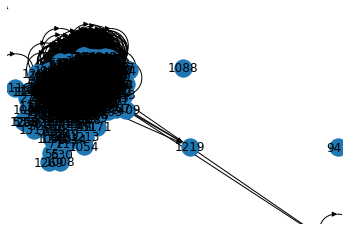

In [11]:
def save_graph(graph):
    #initialze Figure
    plt.figure()
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig("graph.pdf")
    del fig

save_graph(G)

['G:min/b7', 'C:maj/4', 'Gb:dim', 'C#:maj/2', 'F#:min7(s5,*5)', 'D:min(b7,9,11)/b3', 'Bb:7/5', 'D:7/3', 'Db:maj(b7,b9,11,13)', 'G:(1,4)/b5', 'Db:min(b7,9,11)', 'Ab:maj/b6', 'G:min/b3', 'A:9(b5,*5)', 'A:min6/2', 'G:6(9)', 'F:sus4(b7)', 'Bb:(1,5)/2', 'Bbb:7(s9)', 'E:7(b9)', 'F:maj/2', 'D:maj9(#11)', 'Db:aug(b7,9)', 'E:(1,5)', 'G:maj(b7,b9,s11,13)', 'D:7(s5,*5,s9)', 'B:7(b9)/5', 'B:9/3', 'D:min/7', 'Gb:maj(b7,9,s11,13)', 'F:7(b5,*5,b9)', 'F:min9/4', 'Eb:maj', 'C:aug(b7,9)', 'F:sus4(b7,9)', 'A:maj/2', 'Bb:7/b7', 'Eb:min', 'Cb:hdim', 'C:maj7/5', 'Eb:maj(7,9,11,13)', 'G#:(1,b3,b5)', 'D#:dim/3', 'E:min9/5', 'F:9(s11)', 'F:maj6/3', 'Ab:(1,5)/6', 'F:min6/5', 'G:(1,4,5,b7,9,11,13)', 'G#:min6', 'G:7/6', 'C:min9', 'Ab:min7/4', 'Bbb:7(b13)', 'Ab:maj9(#11)', 'E:sus4(b7)/5', 'Bb:maj/7', 'A:min/b2', 'Db:9(s11)', 'A:maj7/7', 'E:dim/b5', 'Bb:maj/2', 'Bb:maj(b7,9,11,13)/3', 'A:min6/5', 'D:min(b7,9,11)/4', 'Ab:9', 'C:hdim', 'D:7(b5,*5)/b5', 'A:hdim/b3', 'A:aug(b7)/4', 'C#:aug', 'F#:sus4(b7)/b3', 'G#:maj7/